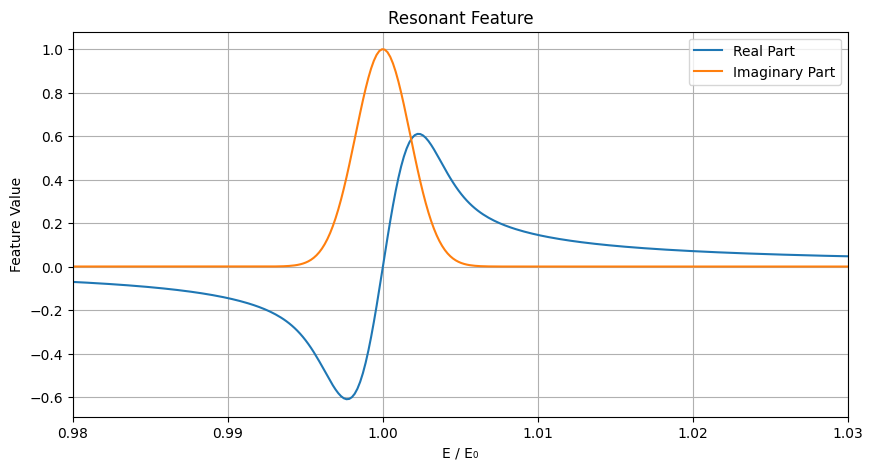

In [103]:
import numpy as np
from scipy.special import dawsn
import matplotlib.pyplot as plt


def resonant_feature(energy, resonance, width, amplitude=1.0) -> np.ndarray:
    """
    Functional form of a resonant feature with gaussian-like dispersion.

    The imaginary part of the feature is modeled as a gaussian shape function,
    centered at a resonance energy, with a specified width. The real part is
    then the dawson function defined though the dawson integral.

    P(E, R, W, A) = A * (dawson((E - R) / W) + i * exp(-(E - R)^2 / (2 * W^2)))

    Parameters:
    -----------
    energy : float or np.ndarray
        Energy at which to evaluate the feature.
    resonance : float
        Resonance energy.
    width : float
        Width of the resonance.
    amplitude : float, optional
        Amplitude of the resonance, default is 1.0.

    Returns:
    --------
    np.ndarray
        The value of the resonant feature at the specified energy.
    """
    if isinstance(energy, (int, float)):
        energy = np.array([energy])

    # Calculate the imaginary part
    imag_part = amplitude * np.exp(-1 / 2 * ((energy - resonance) / width) ** 2)
    real_part = (
        2
        / np.sqrt(np.pi)
        * amplitude
        * dawsn(1 / np.sqrt(2) * (energy - resonance) / width)
    )

    # Combine real and imaginary parts
    return real_part + 1j * imag_part


#  plot this
energy = np.linspace(250, 300, 1000)
resonance = 284
width = 0.5
amplitude = 1
feature = resonant_feature(energy, resonance, width, amplitude)
plt.figure(figsize=(10, 5))
plt.plot(energy / resonance, feature.real, label="Real Part")
plt.plot(energy / resonance, feature.imag, label="Imaginary Part")
plt.title("Resonant Feature")
plt.xlabel("E / E₀")
plt.xlim(0.98, 1.03)
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


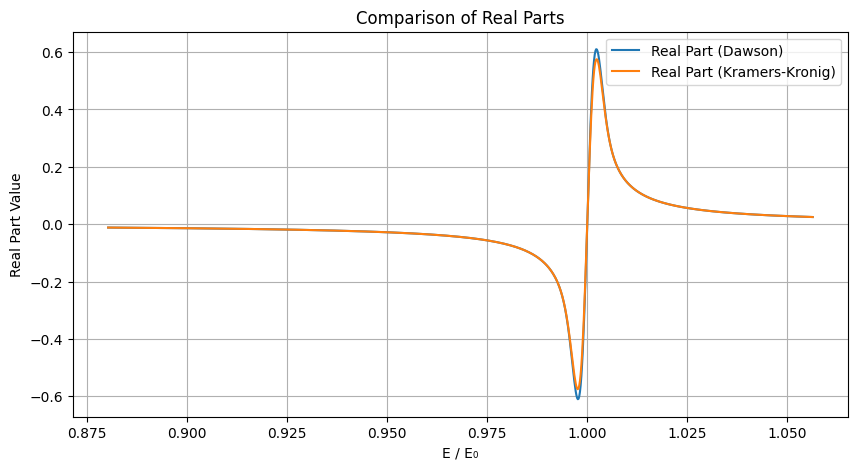

In [252]:
def imag_to_real(peak: np.ndarray, energy: np.ndarray) -> np.ndarray:
    """
    Convert the imaginary part of a resonant feature to its real part.

    This function uses the kramers-kronig relation to compute the real part
    of the resonant response from the imaginary part for a series of energies.

    Parameters:
    -----------
    peak : float
        The peak value of the imaginary part.
    energy : float or np.ndarray
        Energy at which to evaluate the real part.

    Returns:
    --------
    np.ndarray
        The real part of the resonant feature at the specified energy.
    """
    # Use the trapz method to compute the integral
    real_part = np.zeros_like(energy, dtype=np.float64)
    for i, e in enumerate(energy):
        #  for the principal value integral, we need to avoid division by zero
        if i == 0:
            integral = np.trapezoid(peak[1:] / (e - energy[1:]), energy[1:])
        elif i == len(energy) - 1:
            integral = np.trapezoid(
                peak[:i] / (e - energy[:i]), energy[:i]
            ) + np.trapezoid(peak[i + 1 :] / (e - energy[i + 1 :]), energy[i + 1 :])
        else:
            integral = np.trapezoid(
                peak[:i] / (e - energy[:i]), energy[:i]
            ) + np.trapezoid(peak[i + 1 :] / (e - energy[i + 1 :]), energy[i + 1 :])
        real_part[i] = 1 / np.pi * integral
    return real_part


# Compare the results
kk_real_part = imag_to_real(feature.imag, energy)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(energy / resonance, feature.real, label="Real Part (Dawson)")
ax.plot(energy / resonance, kk_real_part, label="Real Part (Kramers-Kronig)")
ax.set_title("Comparison of Real Parts")
ax.set_xlabel("E / E₀")
ax.set_ylabel("Real Part Value")
ax.legend()
ax.grid()
plt.show()

In [253]:
ip = np.mean([291.96863, 290.45758, 290.19235, 290.1377])

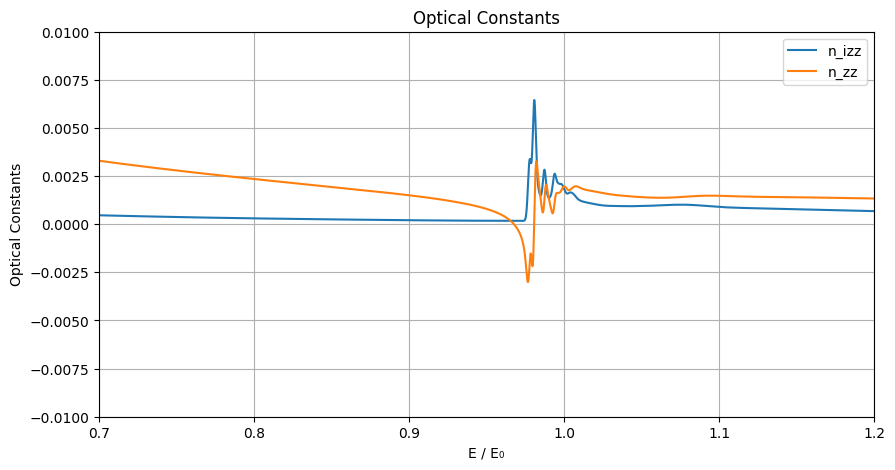

In [302]:
import pandas as pd

#  Now let's load in a sample optical model and plot it, this will be fit later on
df = pd.read_csv("/home/hduva/projects/xrr_notebooks/fitting/optical_constants.csv")
#  Slice to 250 - 300 eV
# df = df[(df["energy"] >= 200) & (df["energy"] <= 360)]
df["e/ip"] = df["energy"] / ip
df.plot(x="e/ip", y=["n_izz", "n_zz"], figsize=(10, 5))
plt.title("Optical Constants")
plt.xlabel("E / E₀")
plt.ylabel("Optical Constants")
plt.xlim(0.7, 1.2)
plt.ylim(-1e-2, 1e-2)
plt.grid()

In [304]:
#  Convert everything to the isotropic tensor.
df["n_i"] = (2 * df["n_ixx"] + df["n_izz"]) / 3
df["n_r"] = (2 * df["n_xx"] + df["n_zz"]) / 3

In [305]:
from kkcalc import kk

n_i = pd.read_csv("/home/hduva/projects/xrr_notebooks/fitting/step_edge_normalized.csv")
#  Calculate the real part of the n_i array using the Kramers-Kronig relation
calc_step = kk.kk_calculate_real(
    n_i[["energy", "Intensity"]].values,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[283, 320],
    add_background=False,
    curve_tolerance=0.001,
    curve_recursion=200,
)

stoichiometry = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoichiometry)

n_r = kk.data.convert_data(
    calc_step[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)

n_i = kk.data.convert_data(
    calc_step[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

# Interpolate the n_i and n_r to the same energy grid as df
n_i = np.interp(df["energy"].values, n_i[:, 0], n_i[:, 1])
n_r = np.interp(df["energy"].values, n_r[:, 0], n_r[:, 1])
#  Calculate a scale factor to match the n_i and n_r to the df values

In [306]:
peaks = [
    284.22241,
    285.06207,
    285.50906,
    286.10214,
    286.74417,
    287.07013,
    287.61008,
    288.15906,
    288.56741,
    288.87015,
    289.379,
    290.20575,
    291.74933,
    293.49863,
    295.36945,
    298.51926,
    303.15958,
    307.15552,
    313.49893,
]
widths = [
    0.68722975,
    0.63484478,
    0.78866369,
    0.73099136,
    0.68295568,
    0.57366711,
    0.60283935,
    0.64840037,
    0.51148295,
    0.6116873,
    0.87610269,
    1.0846148,
    2.0258183,
    2.5669038,
    3.1504252,
    5.0322709,
    6.6183276,
    7.6663713,
    9.2411699,
]
#  Convert the widths to sigma from FWHM
widths = [w / 2.35482 for w in widths]  # FWHM to sigma conversion

In [309]:
from scipy.optimize import curve_fit


def multi_gaussian_with_bare_atom(energy, *params):
    """
    Model function for multiple gaussian peaks plus bare atom contribution.
    params should be [center1, width1, amp1, center2, width2, amp2, ...]
    """
    # Start with bare atom contribution (constant, not fitted)
    result = np.copy(n_i)

    n_peaks = len(params) // 3

    for i in range(n_peaks):
        center = params[i * 3]
        width = params[i * 3 + 1]
        amplitude = params[i * 3 + 2]
        result += resonant_feature(energy, center, width, amplitude).imag

    return result


# Set up initial parameters and bounds for all peaks
n_peaks = len(peaks)
p0 = []
lower_bounds = []
upper_bounds = []

for i, peak_idx in enumerate(peaks):
    center = peak_idx
    initial_width = widths[i]
    # Subtract bare atom contribution from initial amplitude estimate
    # Use interpolation to find the initial amplitude at the peak energy
    initial_amp = np.interp(
        peak_idx, df["energy"].values, df["n_i"].values
    ) - np.interp(peak_idx, df["energy"].values, n_i)
    if initial_amp < 0:
        n_peaks -= 1
        continue  # Skip peaks with negative amplitude

    # Initial parameters: [center, width, amplitude]
    p0.extend([center, initial_width, initial_amp])

    # Bounds: allow center to vary within ±2 eV, width > 0, amplitude > 0
    lower_bounds.extend([center - 0.001, initial_width / 2, 0])
    upper_bounds.extend([center + 0.001, initial_width * 2, initial_amp * 5])

# Fit all peaks simultaneously
# Check if we have any peaks to fit
if n_peaks > 0:
    popt, pcov = curve_fit(
        multi_gaussian_with_bare_atom,
        df["energy"].values,
        df["n_i"].values,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
        maxfev=5000,
    )
else:
    print("No peaks with positive amplitude found. Using bare atom contribution only.")
    popt = []  # Empty parameters
    pcov = np.array([])  # Empty covariance matrix

# Generate the fitted curve
fitted_curve = multi_gaussian_with_bare_atom(df["energy"].values, *popt)

In [321]:
# Extract individual peak parameters
fitted_peaks = []
for i in range(n_peaks):
    center = popt[i * 3]
    width = popt[i * 3 + 1]
    amplitude = popt[i * 3 + 2]
    fitted_peaks.append((center, width, amplitude))
    # print(
    #     f"Peak {i + 1}: Center={center:.2f} eV, Width={width:.3f} eV, Amplitude={amplitude:.4f}"
    # )

# Calculate real parts for fitted curve
fitted_real_curve = np.copy(n_r)
for i, (center, width, amplitude) in enumerate(fitted_peaks):
    fitted_real_curve += resonant_feature(
        df["energy"].values, center, width, amplitude
    ).real

calc_real_part = kk.kk_calculate_real(
    np.column_stack((df["energy"].values, fitted_curve)),
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[250, 330],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)

stoichiometry = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoichiometry)

fitted_delta = kk.data.convert_data(
    calc_real_part[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)

fitted_beta = kk.data.convert_data(
    calc_real_part[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

fitted_delta = np.interp(df["energy"].values, fitted_delta[:, 0], fitted_delta[:, 1])
fitted_beta = np.interp(df["energy"].values, fitted_beta[:, 0], fitted_beta[:, 1])

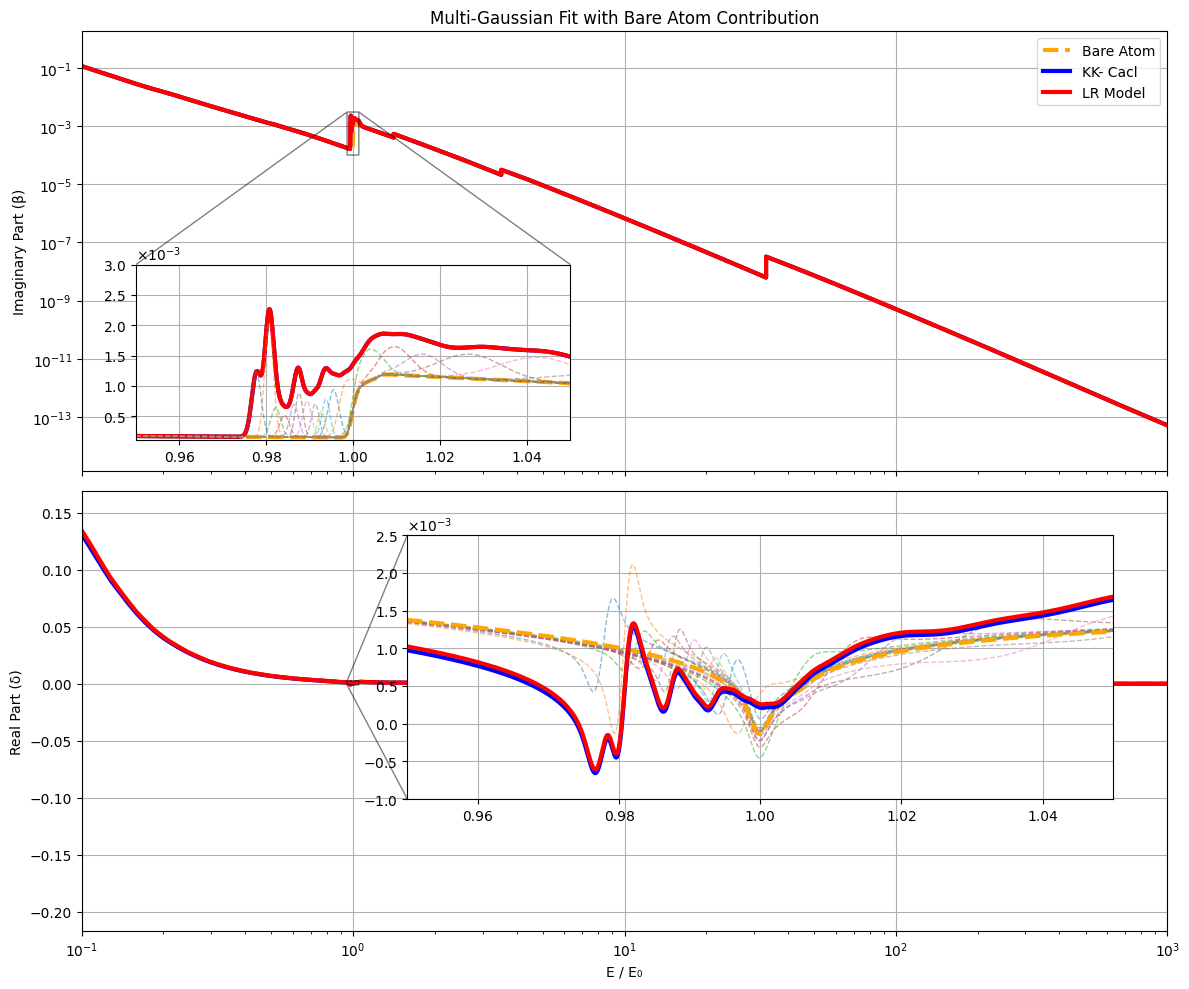

R-squared: 0.9997


In [364]:
# Plot results with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top plot: Imaginary parts
ax1.plot(
    df["e/ip"],
    n_i,
    label="Bare Atom",
    linestyle="--",
    color="orange",
    lw=3,
)
ax1.plot(
    df["e/ip"],
    fitted_beta,
    label="KK- Cacl",
    color="blue",
    lw=3,
)
ax1.plot(
    df["e/ip"],
    fitted_curve,
    label="LR Model",
    color="red",
    lw=3,
)

ax1.set_title("Multi-Gaussian Fit with Bare Atom Contribution")
ax1.set_ylabel("Imaginary Part (β)")
ax1.legend()
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid()
#  Do an inset zoom axis to .95 - .105, placing the axis to the bottom left
inset_ax1 = ax1.inset_axes([0.05, 0.07, 0.4, 0.4])  # [x, y, width, height]
# Set scientific notation on the y axis
inset_ax1.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)
inset_ax1.plot(
    df["e/ip"],
    n_i,
    label="Bare Atom",
    linestyle="--",
    color="orange",
    lw=3,
)
inset_ax1.plot(
    df["e/ip"],
    fitted_beta,
    label="KK- Cacl",
    color="blue",
    lw=3,
)
inset_ax1.plot(
    df["e/ip"],
    fitted_curve,
    label="LR Model",
    color="red",
    lw=3,
)
for i in range(n_peaks):
    center = popt[i * 3]
    width = popt[i * 3 + 1]
    amplitude = popt[i * 3 + 2]
    inset_ax1.plot(
        df["e/ip"],
        resonant_feature(df["energy"].values, center, width, amplitude).imag + n_i,
        lw=1,
        alpha=0.5,
        linestyle="--",
    )
inset_ax1.set_xlim(0.95, 1.05)
inset_ax1.set_ylim(1e-4, 3e-3)
inset_ax1.grid()
#  Show inset zoom
ax1.indicate_inset_zoom(inset_ax1, edgecolor="black", alpha=0.5)

# Bottom plot: Real parts
ax2.plot(df["e/ip"], n_r, linestyle="--", color="orange", lw=3)
ax2.plot(df["e/ip"], fitted_delta, color="blue", lw=3)
ax2.plot(
    df["e/ip"],
    fitted_real_curve,
    color="red",
    lw=3,
)
ax2.set_xscale("log")
# ax2.set_yscale("log")
#  Zoom in from 1 to 1000
ax2.set_xlim(1e-1, 1e3)
# ax2.set_ylim(-1e-3, 3e-3)

ax2.set_ylabel("Real Part (δ)")
ax2.set_xlabel("E / E₀")
# ax2.legend()
ax2.grid()
#  Do an inset zoom axis to .95 - .105, placing the axis to the top right
inset_ax2 = ax2.inset_axes([0.3, 0.3, 0.65, 0.6])  # [x, y, width, height]
# Set scientific notation on the y axis
inset_ax2.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)

for i in range(n_peaks):
    center = popt[i * 3]
    width = popt[i * 3 + 1]
    amplitude = popt[i * 3 + 2]
    inset_ax2.plot(
        df["e/ip"],
        resonant_feature(df["energy"].values, center, width, amplitude).real + n_r,
        lw=1,
        alpha=0.5,
        linestyle="--",
    )
inset_ax2.plot(df["e/ip"], n_r, linestyle="--", color="orange", lw=3)
inset_ax2.plot(df["e/ip"], fitted_delta, color="blue", lw=3)
inset_ax2.plot(
    df["e/ip"],
    fitted_real_curve,
    color="red",
    lw=3,
)
inset_ax2.set_xlim(0.95, 1.05)
inset_ax2.set_ylim(-1e-3, 2.5e-3)
inset_ax2.grid()
#  Show inset zoom
ax2.indicate_inset_zoom(inset_ax2, edgecolor="black", alpha=0.5)


plt.tight_layout()
plt.show()

# Calculate R-squared for goodness of fit
ss_res = np.sum((df["n_izz"].values - fitted_curve) ** 2)
ss_tot = np.sum((df["n_izz"].values - np.mean(df["n_izz"].values)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")


In [299]:
def rmspe(data1, data2):
    """
    Calculate the Root Mean Square Percent Error (RMSPE) between two datasets.

    Parameters:
    -----------
    data1 : np.ndarray
        First dataset (e.g., fitted values).
    data2 : np.ndarray
        Second dataset (e.g., original values).

    Returns:
    --------
    float
        The RMSPE value.
    """
    if len(data1) != len(data2):
        raise ValueError("Input arrays must have the same length.")
    if np.any(data2 == 0):
        raise ValueError(
            "data2 must not contain zero values to avoid division by zero."
        )
    # Calculate RMSPE
    return np.sqrt(np.mean((data1 - data2) ** 2)) / np.mean(data2) * 100


real_rmspe = rmspe(df["n_r"].values, fitted_real_curve)
imag_rmspe = rmspe(df["n_i"].values, fitted_curve)
print(f"RMSPE for Real Part: {real_rmspe:.4f}%")
print(f"RMSPE for Imaginary Part: {imag_rmspe:.4f}%")

RMSPE for Real Part: 4.4765%
RMSPE for Imaginary Part: 0.5159%


In [ ]:
#  Re - calculate the real part from the imaginary part as a check


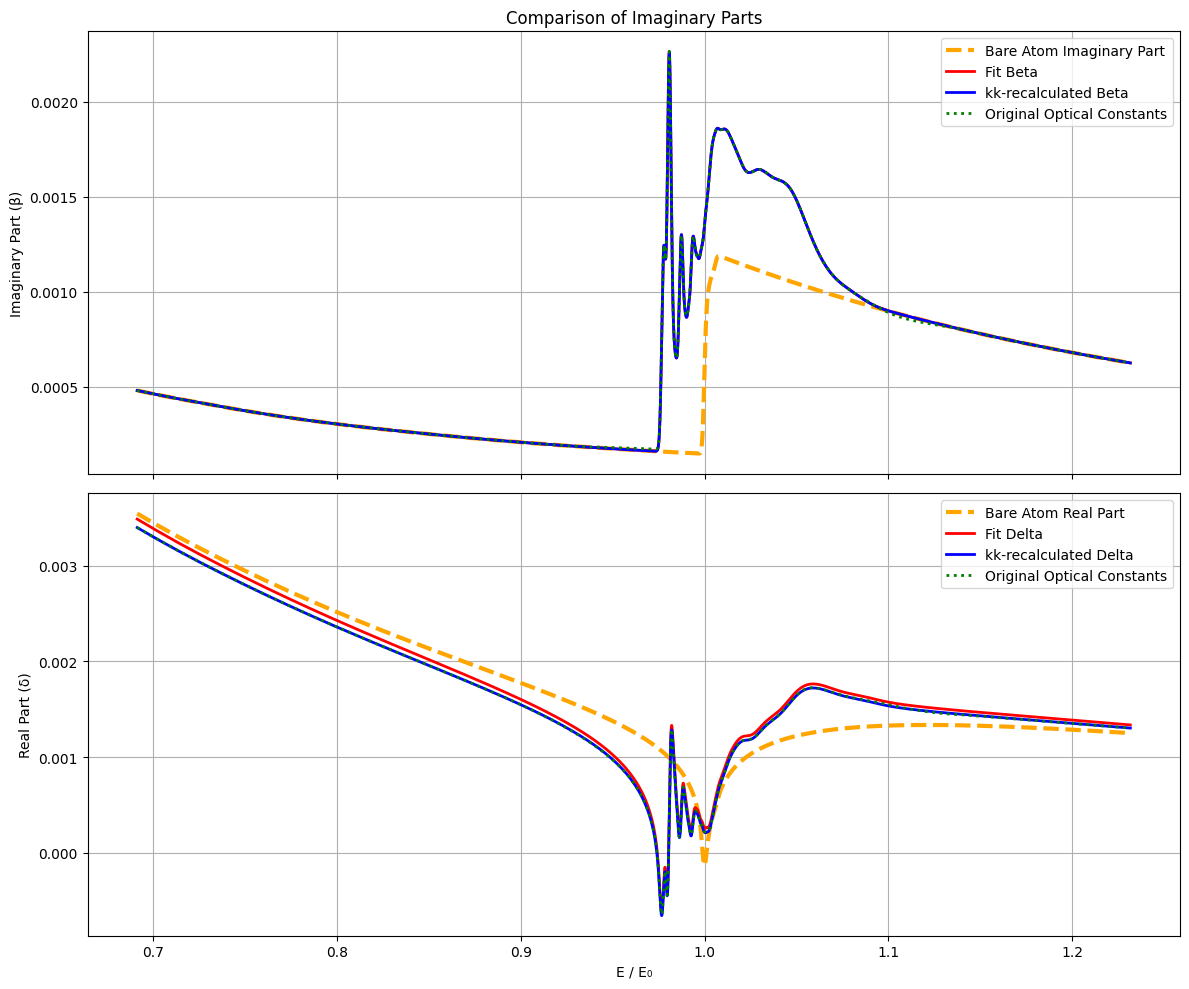

In [301]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# Top plot: Imaginary parts
ax1.plot(
    df["e/ip"],
    n_i,
    label="Bare Atom Imaginary Part",
    linestyle="--",
    color="orange",
    lw=3,
)
ax1.plot(
    df["e/ip"],
    fitted_curve,
    label="Fit Beta",
    linestyle="-",
    color="red",
    lw=2,
)
ax1.plot(
    df["e/ip"],
    fitted_beta,
    label="kk-recalculated Beta",
    linestyle="-",
    color="blue",
    lw=2,
)
ax1.plot(
    df["e/ip"],
    df["n_i"],
    label="Original Optical Constants",
    linestyle=":",
    color="green",
    lw=2,
)
ax1.set_title("Comparison of Imaginary Parts")
ax1.set_ylabel("Imaginary Part (β)")
ax1.legend()
ax1.grid()

# Bottom plot: Real parts
ax2.plot(
    df["e/ip"], n_r, label="Bare Atom Real Part", linestyle="--", color="orange", lw=3
)
ax2.plot(
    df["e/ip"],
    fitted_real_curve,
    label="Fit Delta",
    linestyle="-",
    color="red",
    lw=2,
)
ax2.plot(
    df["e/ip"],
    fitted_delta,
    label="kk-recalculated Delta",
    linestyle="-",
    color="blue",
    lw=2,
)
ax2.plot(
    df["e/ip"],
    df["n_r"],
    label="Original Optical Constants",
    color="green",
    lw=2,
    linestyle=":",
)
ax2.set_ylabel("Real Part (δ)")
ax2.set_xlabel("E / E₀")
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

In [291]:
def rmspe(data1, data2):
    """
    Calculate the Root Mean Square Percent Error (RMSPE) between two datasets.

    Parameters:
    -----------
    data1 : np.ndarray
        First dataset (e.g., fitted values).
    data2 : np.ndarray
        Second dataset (e.g., original values).

    Returns:
    --------
    float
        The RMSPE value.
    """
    #  Mask out any NaN values in data2 to avoid division by zero
    mask = ~np.isnan(data2)
    #  Instersect the mask with the NaN values in data1
    mask &= ~np.isnan(data1)
    data1 = data1[mask]
    data2 = data2[mask]
    return np.sqrt(np.mean((data1 - data2) ** 2)) / np.mean(data2) * 100


print(f"RMSPE (Imaginary Part): {rmspe(fitted_beta, fitted_curve):.4f}%")
print(f"RMSPE (Real Part): {rmspe(fitted_delta, fitted_real_curve):.4f}%")

RMSPE (Imaginary Part): 0.0013%
RMSPE (Real Part): 4.8253%


In [292]:
#  Calculate the difference between the real part and the fitted real part
real_diff = fitted_delta - fitted_real_curve
#  Determine the mean and standard deviation of the difference
mean_diff = np.mean(real_diff)
std_diff = np.std(real_diff)
print(f"Mean Difference: {mean_diff:.6f}")
print(f"Standard Deviation of Difference: {std_diff:.6f}")
#  Calculate the reatios between the real part and the fitted real part
ratios = fitted_delta / fitted_real_curve
#  Determine the mean and standard deviation of the ratios
mean_ratio = np.mean(ratios)
std_ratio = np.std(ratios)
print(f"Mean Ratio: {mean_ratio:.6f}")
print(f"Standard Deviation of Ratio: {std_ratio:.6f}")

Mean Difference: -0.000046
Standard Deviation of Difference: 0.000005
Mean Ratio: 0.965014
Standard Deviation of Ratio: 1.570748


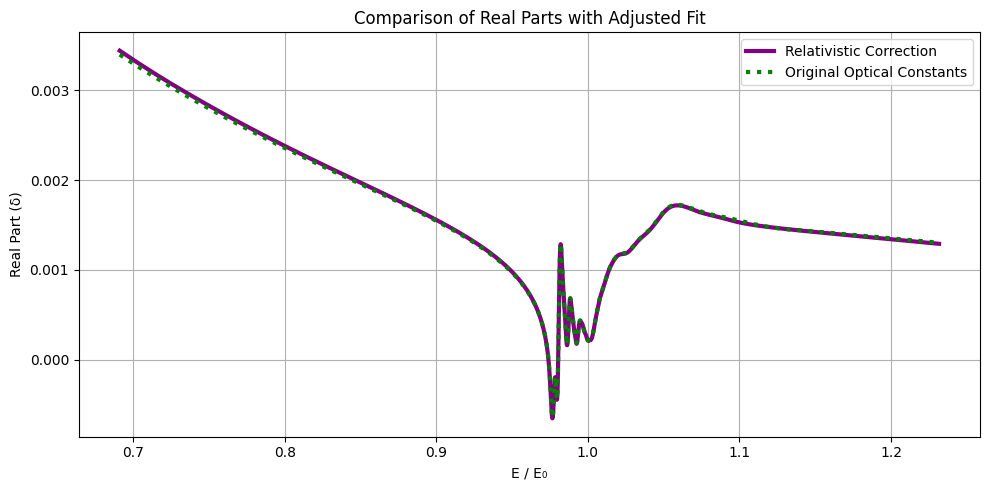

RMSPE (Adjusted Real Part): 0.8716%


In [293]:
#  Try multiplying the real part by the ratio to see if it improves the fit
fitted_real_curve_adjusted = fitted_real_curve * ratios
fitted_reletivisitic_correction = fitted_real_curve + mean_diff
#  Plot the adjusted real part
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(
#     df["e/ip"],
#     n_r,
#     label="Bare Atom Real Part",
#     linestyle="--",
#     color="orange",
#     lw=3,
# )
# ax.plot(
#     df["e/ip"],
#     fitted_real_curve,
#     label="Fit Delta",
#     linestyle="-",
#     color="red",
#     lw=2,
# )
ax.plot(
    df["e/ip"],
    fitted_reletivisitic_correction,
    label="Relativistic Correction",
    linestyle="-",
    color="purple",
    lw=3,
)
ax.plot(
    df["e/ip"],
    df["n_r"],
    label="Original Optical Constants",
    color="green",
    lw=3,
    linestyle=":",
)
ax.set_title("Comparison of Real Parts with Adjusted Fit")
ax.set_ylabel("Real Part (δ)")
ax.set_xlabel("E / E₀")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()
print(
    f"RMSPE (Adjusted Real Part): {rmspe(fitted_reletivisitic_correction, df['n_r'].values):.4f}%"
)

In [294]:
#  Calculate an exact reletivistic correction for the real part
rel_correction = kk.calc_relativistic_correction(stoichiometry)
rel_correction

293.82129972077894

Energy: 200.932, Wavelength: 6.1704555985706746e-09


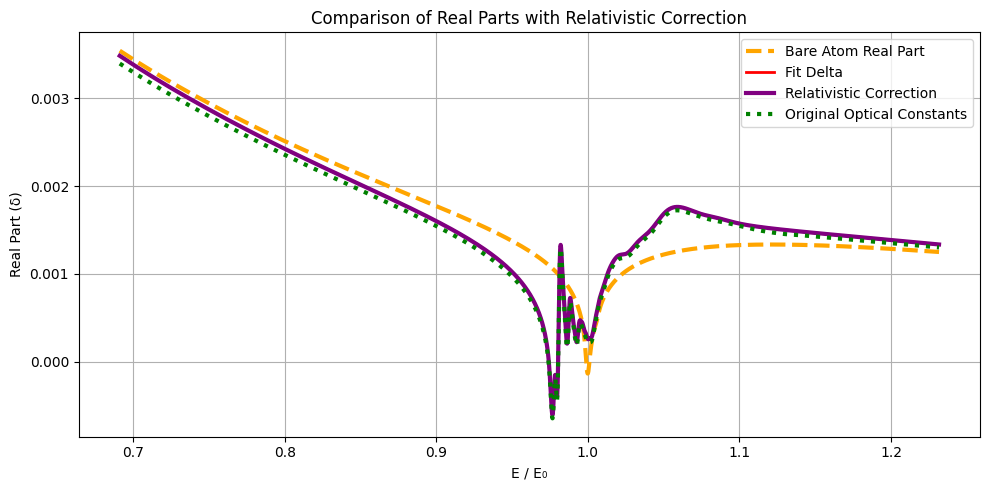

In [295]:
#  Convert the reletivistic correction to index of refraction units
from scipy.constants import physical_constants


def f_to_n(f, energy: np.ndarray) -> np.ndarray:
    """
    Convert atomic scattering factor to index of refraction units.

    Parameters:
    -----------
    f : float or np.ndarray
        Atomic scattering factor in [# electrons].
    energy : np.ndarray
        Energy in [eV] at which to calculate the index of refraction.

    Returns:
    --------
    float or np.ndarray
        Index of refraction.
    """
    r_e = physical_constants["classical electron radius"][0]  # in meters
    h = physical_constants["Planck constant"][0]  # in J s
    c = physical_constants["speed of light in vacuum"][0]  # in m/s
    eV_to_J = physical_constants["electron volt"][0]  # in J
    # Calculate the wavelength in meters
    wavelength = h * c / (energy * eV_to_J)  # in meters
    print(f"Energy: {energy[0]}, Wavelength: {wavelength[0]}")
    # Calculate the index of refraction
    n_units = r_e * wavelength**2 * f / 2 / np.pi
    return n_units


z_star = f_to_n(rel_correction, df["energy"].values)
#  Now determine delta the real part implementing the relativistic correction
delta_rel = fitted_real_curve + z_star
#  Plot the adjusted real part
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    df["e/ip"],
    n_r,
    label="Bare Atom Real Part",
    linestyle="--",
    color="orange",
    lw=3,
)
ax.plot(
    df["e/ip"],
    fitted_real_curve,
    label="Fit Delta",
    linestyle="-",
    color="red",
    lw=2,
)
ax.plot(
    df["e/ip"],
    delta_rel,
    label="Relativistic Correction",
    linestyle="-",
    color="purple",
    lw=3,
)
ax.plot(
    df["e/ip"],
    df["n_r"],
    label="Original Optical Constants",
    color="green",
    lw=3,
    linestyle=":",
)
ax.set_title("Comparison of Real Parts with Relativistic Correction")
ax.set_ylabel("Real Part (δ)")
ax.set_xlabel("E / E₀")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [296]:
print(
    f"RMSPE (Relativistic Corrected Real Part): {rmspe(delta_rel, df['n_r'].values):.4f}%",
    f"RMSPE (Non Corrected Real Part): {rmspe(fitted_real_curve, df['n_r'].values):.4f}%",
)

RMSPE (Relativistic Corrected Real Part): 4.6833% RMSPE (Non Corrected Real Part): 4.6833%
